## **Airbnb price prediction with Machine Learning**

### **Some variables description**

- `host_since`: date that the host first joined Airbnb

- `host_response_time`: average amount of time the host takes to reply to messages

- `host_response_rate`: proportion of messages that the host replies to

- `host_is_superhost`: whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb

- `host_listings_count`: how many listings the host has in total

- `host_identity_verified`: whether or not the host has been verified with id

- `neighbourhood_cleansed`: the Lisbon borough the property is in

- `property_type`: type of property, e.g. house or flat

- `room_type`: type of listing, e.g. entire home, private room or shared room

- `accommodates`: how many people the property accommodates

- `bathrooms`: number of bathrooms

- `bedrooms`: number of bedrooms

- `beds`: number of beds

- `amenities`: list of amenities

- `price`: nightly advertised price (target variable)

- `minimum_nights`: the minimum length of stay

- `maximum_nights`: the maximum length of stay

- `calendar_updated`: when the host last updated the calendar

- `availability_30`: how many nights are available to be booked in the next 30 days

- `availability_60`: how many nights are available to be booked in the next 60 days

- `availability_90`: how many nights are available to be booked in the next 90 days

- `availability_365`: how many nights are available to be booked in the next 365 days

- `number_of_reviews`: the number of reviews left for the property

- `number_of_reviews_ltm`: the number of reviews left for the property in the last twelve months

- `first_review`: the date of the first review

- `last_review`: the date of the most recent review

- `review_scores_rating`: guests can score properties overall from 1 to 5 stars

- `review_scores_accuracy`: guests can score the accuracy of a property's description from 1 to 5 stars

- `review_scores_cleanliness`: guests can score a property's cleanliness from 1 to 5 stars

- `review_scores_checkin`: guests can score their check-in from 1 to 5 stars

- `review_scores_communication`: guests can score a host's communication from 1 to 5 stars

- `review_scores_location`: guests can score a property's location from 1 to 5 stars

- `review_scores_value`: guests can score a booking's value for money from 1 to 5 stars

- `instant_bookable`: whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)

- `reviews_per_month`: calculated field of the average number of reviews left by guest each month

### **Data Cleaning and pre-processing**

In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

In [2]:
# Import data
df1 = pd.read_csv('listings.csv.gz')


print(f"The dataset contains {len(df1)} Airbnb listings.")

The dataset contains 24204 Airbnb listings.


##### Drop columns not needed

In [3]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name','description', 'neighborhood_overview', 'picture_url', 'host_id',
'host_url', 'host_name', 'host_since', 'host_location', 'host_about','host_response_time', 'host_response_rate', 'host_acceptance_rate',
'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_verifications','host_has_profile_pic', 'host_identity_verified', 
'neighbourhood', 'property_type', 'bedrooms',
'bathrooms_text', 'beds', 'amenities', 'minimum_minimum_nights',
'maximum_minimum_nights', 'minimum_maximum_nights','maximum_maximum_nights', 'minimum_nights_avg_ntm',
'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_60', 'availability_90',
'availability_365', 'calendar_last_scraped','number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
'last_review', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
'review_scores_communication', 'review_scores_location','review_scores_value', 'license', 'instant_bookable',
'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms', 'reviews_per_month','calculated_host_listings_count_entire_homes',
'calculated_host_listings_count']
df1 = df1.drop(cols_to_drop, axis=1)

##### Drop columns with `Null` entries and duplicates

In [4]:
df1.isna().sum()

id                                 0
host_is_superhost                870
host_total_listings_count          0
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
room_type                          0
accommodates                       0
bathrooms                       2978
price                           2971
minimum_nights                     0
maximum_nights                     0
availability_30                    0
number_of_reviews                  0
review_scores_rating            3052
dtype: int64

In [5]:
df1.duplicated().sum()

0

In [6]:
df1 = df1.dropna()
df1 = df1.drop_duplicates()
# ID as index
df1.set_index('id', inplace=True)

In [7]:
len(df1)

18084

In [8]:
df1.dtypes

host_is_superhost                object
host_total_listings_count         int64
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
room_type                        object
accommodates                      int64
bathrooms                       float64
price                            object
minimum_nights                    int64
maximum_nights                    int64
availability_30                   int64
number_of_reviews                 int64
review_scores_rating            float64
dtype: object

##### Data transformation

In [9]:
# Rename columns to simplify names
df1 = df1.rename(columns={'host_is_superhost': 'superhost'})
df1 = df1.rename(columns={'number_of_reviews': 'reviews'})
df1 = df1.rename(columns={'review_scores_rating': 'ratings'})

# Create a new column 'professional_host' indicating if a host has 2 or more listings (1 if yes, 0 if no)
df1['professional_host'] = df1['host_total_listings_count'].apply(lambda x: 1 if x >= 2 else 0)

# Convert 'superhost' column values: replace 'f' with 0 (not superhost) and 't' with 1 (is a superhost)
df1['superhost'] = df1['superhost'].replace({'f': 0, 't': 1})

# Clean and convert the 'price' column: remove dollar signs and commas, then convert to float type
df1['price'] = df1['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
# Convert 'bathrooms' column from float to integer type for consistency
df1['bathrooms'] = df1['bathrooms'].astype(int)

In [10]:
exchange_rate = 0.9683 #4th february 2025  
# Converting dollar to euro
df1["price"] = df1["price"] * exchange_rate

##### Filters

In [11]:
# Filter the DataFrame to include only rows where 'room_type' is 'Entire home/apt'
df1 = df1[df1['room_type'] == 'Entire home/apt']
# Filter to include only rows where 'price' is greater than 0
df1 = df1[df1['price'] > 0]
# Filter to include only rows where 'reviews' is greater than 0
df1 = df1[df1['reviews'] > 0]
# Filter to include only rows where 'availability_30' is greater than 0
df1 = df1[df1['availability_30'] > 0]
# Filter the DataFrame to include only rows where 'neighbourhood_group_cleansed' is 'Lisboa'
df1 = df1[df1['neighbourhood_group_cleansed'] == 'Lisboa']

##### Seach for `outliers`

In [12]:
def z_score_outliers(dta_frame, value, threshold=2):
    """
    Identifies outliers using Z-scores in a column.
    
    Args:
        dta_frame: The pandas Data Frame.
        value: The name of the column containing numerical data.
        threshold: The number of standard deviations for outlier threshold .
    
    Returns:
        A Series containing True for outliers and False for inliers.
    """

    # Calculate mean and standard deviation of the column
    mean = dta_frame[value].mean()
    std = dta_frame[value].std()

    # Calculate Z-scores for each data point in the column
    z_scores = (dta_frame[value] - mean) / std

    # Return boolean Series indicating outliers based on threshold
    return abs(z_scores) > threshold

In [13]:
# Identify outliers using Z-scores
outliers = z_score_outliers(df1, 'price')

# Filter the original Data Frame to get the rows with outliers
filtered_data = df1[outliers] 

# Print the filtered data containing rows with outliers
print(filtered_data)
len(filtered_data)

                     superhost  host_total_listings_count  \
id                                                          
29720                        1                          2   
2945967                      0                          3   
3311704                      1                          2   
5208776                      1                         16   
7223708                      0                          2   
7750915                      0                          4   
9381867                      1                          9   
13663995                     1                          9   
14277124                     1                          9   
15200207                     0                        123   
17628047                     1                          6   
19158268                     0                          6   
19990800                     1                          9   
27222410                     0                          1   
27773402                

46

In [14]:
df1 = df1[~outliers]

In [15]:
len(df1)

8298

#### Location attributes

In [16]:
# Import data for location attributes
gdf1 = gpd.read_file('leisure and sports.geojson')
gdf2 = gpd.read_file('accomodation.geojson')
gdf3 = pd.read_excel('20 popular atrractions in Lisbon.xlsx')
gdf4 = gpd.read_file('subway stations.geojson')

In [17]:
# Create 2 new columns 'latitude' and 'longitude'
gdf1["longitude"] = gdf1.geometry.x
gdf1["latitude"] = gdf1.geometry.y
gdf2["longitude"] = gdf2.geometry.x
gdf2["latitude"] = gdf2.geometry.y
gdf4 = gdf4[~gdf4['geometry'].astype(str).str.startswith('LINESTRING')]
gdf4["longitude"] = gdf4.geometry.x
gdf4["latitude"] = gdf4.geometry.y

##### Dist_hotspots variable

In [18]:
def calculate_dist_hotspots_geopandas(listings_df, attractions_df):
    """
    Calculates 'dist_hotspots' for each listing as a weighted sum of distances to top attractions
    using GeoDataFrames and a metric CRS for distance calculations.

    Args:
    listings_df (DataFrame): The Airbnb listings data containing 'latitude' and 'longitude'.
    attractions_df (DataFrame): The attractions data containing 'latitude', 'longitude', and 'reviews'.

    Returns:
    DataFrame: A DataFrame with a new 'dist_hotspots' column for each listing.
    """

    # Convert listings and attractions data to GeoDataFrames with geometry
    listings_gdf = gpd.GeoDataFrame(
        listings_df, 
        geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude),
        crs="EPSG:4326"  # Set initial CRS to WGS84 (degrees)
    )

    attractions_gdf = gpd.GeoDataFrame(
        attractions_df, 
        geometry=gpd.points_from_xy(attractions_df.longitude, attractions_df.latitude),
        crs="EPSG:4326"
    )

    # Project to a metric CRS (e.g., EPSG:3857 for meters)
    listings_gdf = listings_gdf.to_crs(epsg=3857)
    attractions_gdf = attractions_gdf.to_crs(epsg=3857)

    # Normalize review weights
    attractions_gdf['weight'] = attractions_gdf['reviews'] / attractions_gdf['reviews'].sum()

    # Initialize a list to store 'dist_hotspots' for each listing
    dist_hotspots_values = []

    # Calculate weighted distances for each listing
    for _, listing in listings_gdf.iterrows():
        total_weighted_distance = 0

        # Calculate distances to each attraction, apply weights, and sum
        for _, attraction in attractions_gdf.iterrows():
            distance = listing.geometry.distance(attraction.geometry) / 1000  # Convert to kilometers
            weighted_distance = distance * attraction['weight']
            total_weighted_distance += weighted_distance

        # Append the result
        dist_hotspots_values.append(total_weighted_distance)

    # Add the 'dish_hotspots' column to the listings GeoDataFrame
    listings_gdf['dist_hotspots'] = dist_hotspots_values

    return listings_gdf[['latitude', 'longitude', 'dist_hotspots']]


# Calculate dist_hotspots using GeoPandas
listings_with_dist_hotspots = calculate_dist_hotspots_geopandas(df1,gdf3)
print(listings_with_dist_hotspots)


                      latitude  longitude  dist_hotspots
id                                                      
211616               38.713150  -9.127150       5.199863
220359               38.735130  -9.149040       5.800280
227224               38.711020  -9.129950       5.041075
229846               38.714780  -9.124100       5.427492
6499                 38.697500  -9.197680       6.628886
...                        ...        ...            ...
1235480337052471421  38.709984  -9.134353       4.857750
1235556185353900157  38.714569  -9.128406       5.116087
1238284440670475104  38.711347  -9.139408       4.689712
1238388636234548951  38.713790  -9.144536       4.667561
1236697948245027193  38.704831  -9.172818       5.558913

[8298 rows x 3 columns]


##### Dist_metro variable

In [19]:
def calculate_dist_metro(listings_df, subway_stations_df):
    """
    Calculates 'dist_metro' for each listing as the distance to the nearest subway station.

    Args:
    listings_df (DataFrame): The Airbnb listings data containing 'latitude' and 'longitude'.
    subway_stations_df (DataFrame): The subway station data containing 'latitude' and 'longitude'.

    Returns:
    DataFrame: A DataFrame with a new 'dist_metro' column for each listing, in kilometers.
    """
    
    # Convert listings and subway stations to GeoDataFrames
    listings_gdf = gpd.GeoDataFrame(
        listings_df, 
        geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude),
        crs="EPSG:4326"  # WGS84 lat/lon CRS
    )

    subway_stations_gdf = gpd.GeoDataFrame(
        subway_stations_df,
        geometry=gpd.points_from_xy(subway_stations_df.longitude, subway_stations_df.latitude),
        crs="EPSG:4326"
    )

    # Project both GeoDataFrames to a metric CRS for distance calculation
    listings_gdf = listings_gdf.to_crs(epsg=3857)
    subway_stations_gdf = subway_stations_gdf.to_crs(epsg=3857)

    # Calculate distance to the nearest subway station for each listing
    dist_metro_values = listings_gdf.geometry.apply(lambda x: subway_stations_gdf.distance(x).min() / 1000)  # Convert meters to km

    # Add 'dist_metro' column to listings GeoDataFrame
    listings_gdf['dist_metro'] = dist_metro_values

    return listings_gdf[['latitude', 'longitude', 'dist_metro']]

# Calculate dist_metro
listings_with_dist_metro = calculate_dist_metro(df1, gdf4)
print(listings_with_dist_metro)


                      latitude  longitude  dist_metro
id                                                   
211616               38.713150  -9.127150    0.517354
220359               38.735130  -9.149040    0.210687
227224               38.711020  -9.129950    0.670293
229846               38.714780  -9.124100    0.212013
6499                 38.697500  -9.197680    4.852964
...                        ...        ...         ...
1235480337052471421  38.709984  -9.134353    0.380532
1235556185353900157  38.714569  -9.128406    0.654546
1238284440670475104  38.711347  -9.139408    0.105047
1238388636234548951  38.713790  -9.144536    0.370785
1236697948245027193  38.704831  -9.172818    1.953369

[8298 rows x 3 columns]


##### Num_sports variable

In [20]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def calculate_num_sports(listings_df, sports_pois_df):
    """
    Calculates 'num_sports' for each listing as the number of sports/leisure POIs within 1 km.

    Args:
    listings_df (DataFrame): The Airbnb listings data containing 'latitude' and 'longitude'.
    sports_pois_df (DataFrame): The sports and leisure POIs data containing 'latitude' and 'longitude'.

    Returns:
    DataFrame: A DataFrame with a new 'num_sports' column for each listing.
    """
    
    # Convert listings and sports POIs to GeoDataFrames
    listings_gdf = gpd.GeoDataFrame(
        listings_df, 
        geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude),
        crs="EPSG:4326"  # WGS84 lat/lon CRS
    )

    sports_gdf = gpd.GeoDataFrame(
        sports_pois_df,
        geometry=gpd.points_from_xy(sports_pois_df.longitude, sports_pois_df.latitude),
        crs="EPSG:4326"
    )

    # Project to a metric CRS (e.g., EPSG:3857)
    listings_gdf = listings_gdf.to_crs(epsg=3857)
    sports_gdf = sports_gdf.to_crs(epsg=3857)

    # Buffer each listing by 1 km and count sports POIs within the buffer
    listings_gdf['num_sports'] = listings_gdf.geometry.apply(
        lambda x: sports_gdf[sports_gdf.geometry.within(x.buffer(1000))].shape[0]
    )

    return listings_gdf[['latitude', 'longitude', 'num_sports']]

# Calculate num_sports
listings_with_num_sports = calculate_num_sports(df1, gdf1)
print(listings_with_num_sports)


                      latitude  longitude  num_sports
id                                                   
211616               38.713150  -9.127150          65
220359               38.735130  -9.149040          82
227224               38.711020  -9.129950          70
229846               38.714780  -9.124100          56
6499                 38.697500  -9.197680          72
...                        ...        ...         ...
1235480337052471421  38.709984  -9.134353          57
1235556185353900157  38.714569  -9.128406          75
1238284440670475104  38.711347  -9.139408          63
1238388636234548951  38.713790  -9.144536          84
1236697948245027193  38.704831  -9.172818          77

[8298 rows x 3 columns]


##### Num_accomodation variable

In [21]:
def calculate_num_accomodation(listings_df, hotels_POIs_df):
    """
    Calculates 'num_accomodation' for each listing as the number of accommodation service POIs within 1 km.

    Args:
    listings_df (DataFrame): The Airbnb listings data containing 'latitude' and 'longitude'.
    hotels_POIs_df (DataFrame): The accommodation POIs data containing 'latitude' and 'longitude'.

    Returns:
    DataFrame: A DataFrame with a new 'num_accomodation' column for each listing.
    """
    
    # Convert listings and hotels POIs to GeoDataFrames
    listings_gdf = gpd.GeoDataFrame(
        listings_df, 
        geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude),
        crs="EPSG:4326"  # WGS84 lat/lon CRS
    )

    hotels_gdf = gpd.GeoDataFrame(
        hotels_POIs_df,
        geometry=gpd.points_from_xy(hotels_POIs_df.longitude, hotels_POIs_df.latitude),
        crs="EPSG:4326"
    )

    # Project to a metric CRS (e.g., EPSG:3857)
    listings_gdf = listings_gdf.to_crs(epsg=3857)
    hotels_gdf = hotels_gdf.to_crs(epsg=3857)

    # Buffer each listing by 1 km and count hotels POIs within the buffer
    listings_gdf['num_accomodation'] = listings_gdf.geometry.apply(
        lambda x: hotels_gdf[hotels_gdf.geometry.within(x.buffer(1000))].shape[0]
    )

    return listings_gdf[['latitude', 'longitude', 'num_accomodation']]

# Calculate num_accomodation
listings_with_num_accomodation = calculate_num_accomodation(df1, gdf2)
print(listings_with_num_accomodation)


                      latitude  longitude  num_accomodation
id                                                         
211616               38.713150  -9.127150                63
220359               38.735130  -9.149040                67
227224               38.711020  -9.129950               106
229846               38.714780  -9.124100                37
6499                 38.697500  -9.197680                 5
...                        ...        ...               ...
1235480337052471421  38.709984  -9.134353               147
1235556185353900157  38.714569  -9.128406                93
1238284440670475104  38.711347  -9.139408               185
1238388636234548951  38.713790  -9.144536               180
1236697948245027193  38.704831  -9.172818                 5

[8298 rows x 3 columns]


In [22]:
df1 = (
    df1
    .merge(listings_with_dist_hotspots['dist_hotspots'], on='id')
    .merge(listings_with_dist_metro['dist_metro'], on='id')
    .merge(listings_with_num_sports['num_sports'], on='id')
    .merge(listings_with_num_accomodation[['num_accomodation']], on='id')
)

### **EDA**

In [23]:
#descriptive statistics
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the display width
df1[['price','accommodates', 'bathrooms', 'reviews', 'ratings', 'minimum_nights', 'maximum_nights' ,'superhost', 'professional_host', 'num_sports', 'num_accomodation', 'dist_hotspots', 'dist_metro']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,8298.0,148.281060,82.726811,17.429400,94.893400,124.910700,174.294000,716.542000
accommodates,8298.0,4.080863,2.016347,1.000000,2.000000,4.000000,5.000000,16.000000
bathrooms,8298.0,1.250783,0.544635,0.000000,1.000000,1.000000,1.000000,8.000000
reviews,8298.0,109.255483,117.897968,1.000000,19.000000,67.000000,163.000000,861.000000
ratings,8298.0,4.649411,0.352591,1.000000,4.530000,4.730000,4.860000,5.000000
minimum_nights,8298.0,3.248614,10.531816,1.000000,1.000000,2.000000,3.000000,365.000000
maximum_nights,8298.0,537.451675,467.279404,1.000000,90.000000,365.000000,1125.000000,3000.000000
superhost,8298.0,0.356351,0.478949,0.000000,0.000000,0.000000,1.000000,1.000000
professional_host,8298.0,0.842613,0.364188,0.000000,1.000000,1.000000,1.000000,1.000000
num_sports,8298.0,77.934804,22.943732,10.000000,64.000000,77.000000,89.000000,241.000000


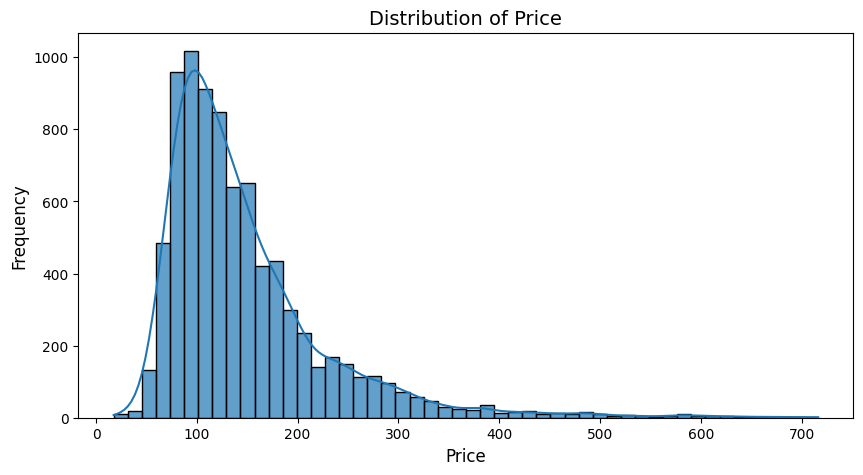

In [24]:

# Set figure size
plt.figure(figsize=(10, 5))

# Plot histogram with KDE (density curve)
sns.histplot(df1['price'], bins=50, kde=True, alpha=0.7)

# Customize labels and title
plt.xlabel("Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Price", fontsize=14)

# Show the plot
plt.show()


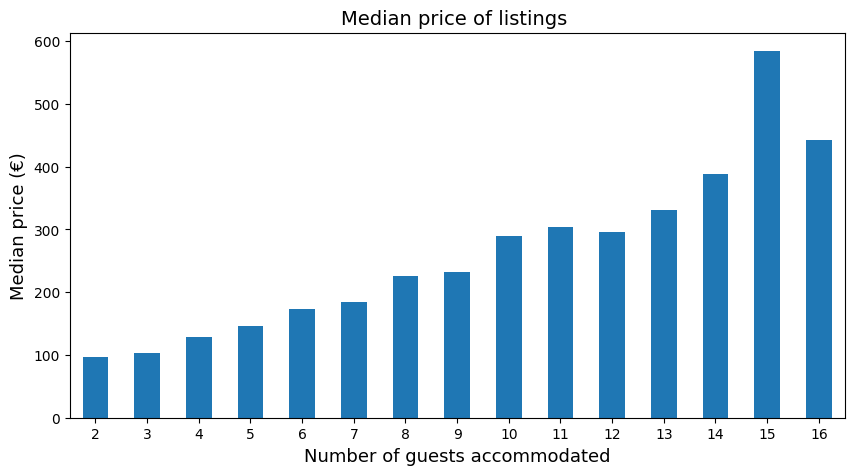

In [25]:
plt.figure(figsize=(10,5))
df1.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of listings ', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (€)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

In [26]:
mean_by_neighbourhood = df1.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
mean_by_neighbourhood

neighbourhood_cleansed
Santo Antnio              163.599728
Misericrdia               162.312102
Santa Maria Maior         161.991578
Parque das Naes           157.713164
Avenidas Novas            153.814175
Santa Clara               151.746443
Arroios                   149.558336
Areeiro                   139.156814
Estrela                   134.621578
Campo de Ourique          131.162087
So Vicente                129.705026
Marvila                   129.299488
So Domingos de Benfica    128.530652
Olivais                   126.325908
Penha de Frana            124.271622
Alcntara                  122.918944
Belm                      118.116726
Campolide                 118.001956
Alvalade                  117.473757
Lumiar                    113.351619
Ajuda                     111.420371
Benfica                   109.560297
Beato                     103.485358
Carnide                    94.893400
Name: price, dtype: float64

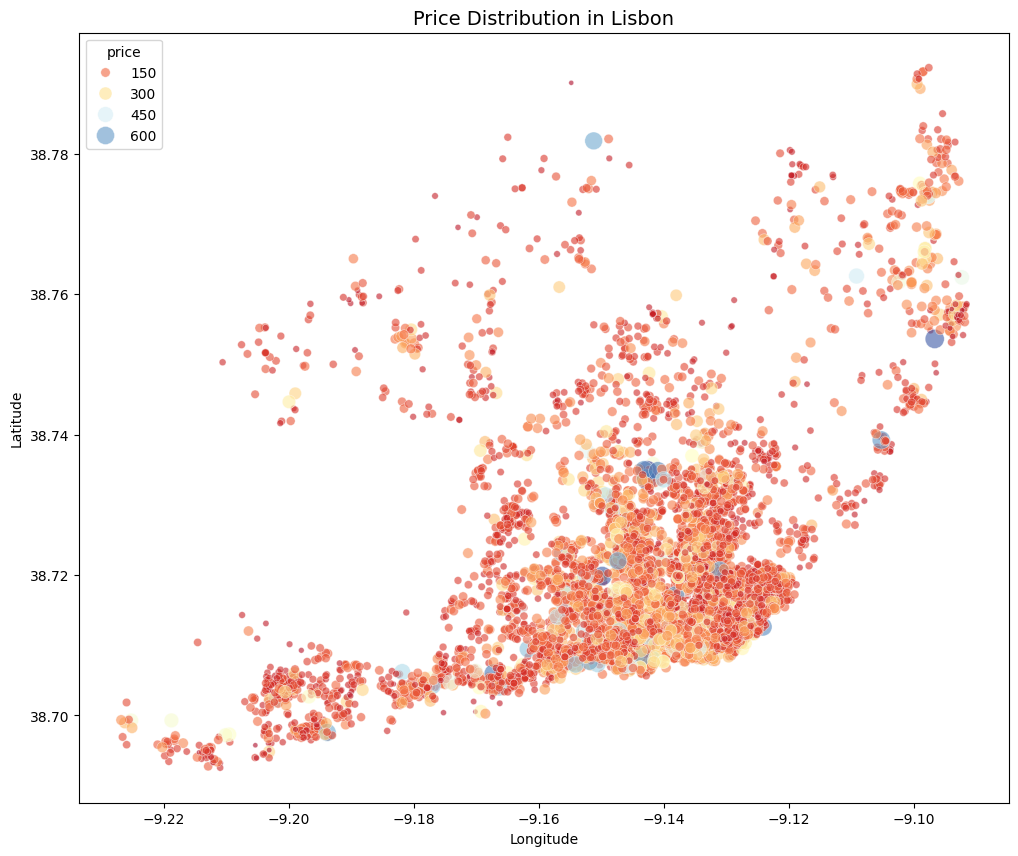

In [27]:

# Set figure size
fig, ax = plt.subplots(figsize=(12, 10))

# Create scatter plot with price color mapping
sns.scatterplot(data=df1, x="longitude", y="latitude", hue='price', palette="RdYlBu", size='price', sizes=(10, 200), alpha=0.6)

# Set title and labels
ax.set_title('Price Distribution in Lisbon', fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


### **Modeling**

In [28]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define dependent and independent variables
X = df1[['accommodates', 'bathrooms', 'reviews', 'ratings', 
         'minimum_nights', 'maximum_nights', 'superhost', 'professional_host', 
         'num_sports', 'num_accomodation', 'dist_hotspots', 'dist_metro']]

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)  

# Add constant for intercept
X_scaled = sm.add_constant(X_scaled)

# Ensure y has the same index as X
y = df1['price'].copy()
y = y.loc[X_scaled.index]  

# Fit the OLS model
ols_model = sm.OLS(y, X_scaled).fit()

# Display results
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     611.7
Date:                Sun, 16 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:25:26   Log-Likelihood:                -45782.
No. Observations:                8298   AIC:                         9.159e+04
Df Residuals:                    8285   BIC:                         9.168e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               148.2811      0.66

In [29]:
y = np.array(df1['price']).reshape((-1, 1))  
X1 = df1[['accommodates', 'bathrooms', 'reviews', 'ratings', 'minimum_nights', 'maximum_nights', 
'superhost', 'professional_host', 'num_sports',  
'num_accomodation', 'dist_hotspots', 'dist_metro']]

scaler = StandardScaler()
X2 = pd.DataFrame(scaler.fit_transform(X1))

X = np.array(X2) 


In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Ensure X is a DataFrame before computing VIF
X_df = pd.DataFrame(X, columns=X1.columns)  # Use original feature names

# Create an empty DataFrame for VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns  # Now this works!

# Compute VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(len(X_df.columns))]

# Print VIF values
print(vif_data)


              feature       VIF
0        accommodates  1.563368
1           bathrooms  1.559270
2             reviews  1.172584
3             ratings  1.212077
4      minimum_nights  1.006080
5      maximum_nights  1.022454
6           superhost  1.250946
7   professional_host  1.013845
8          num_sports  1.190402
9    num_accomodation  1.812785
10      dist_hotspots  1.711257
11         dist_metro  1.486390


##### Geographically weighted regression (GWR)

In [31]:
import pandas as pd 
from mgwr.gwr import GWR 
from mgwr.sel_bw import Sel_BW 
from sklearn.model_selection import KFold 
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

# Extract dependent and independent variables 
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

# y = np.array(df1['price']).reshape((-1, 1))  
# X = np.array(df1[['accommodates', 'bathrooms', 'reviews', 'ratings','minimum_nights', 'maximum_nights',  
# 'superhost', 'professional_host', 'num_sports',  
# 'num_accomodation', 'dist_hotspots', 'dist_metro']]) 


# Coordinates 
coords = np.array(list(zip(df1['longitude'], df1['latitude']))) 

# Set up cross-validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
rmse_scores = [] 
mae_scores = [] 
r2_scores = [] 
mape_scores = [] 


for train_index, test_index in kf.split(X): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 
    coords_train, coords_test = coords[train_index], coords[test_index] 

 
# Train GWR on fold 
bandwidth = Sel_BW(coords_train, y_train, X_train).search() 
gwr_model = GWR(coords_train, y_train, X_train, bandwidth) 
gwr_results = gwr_model.fit() 

# Predict and evaluate 
y_pred = gwr_model.predict(coords_test, X_test).predictions 

 
# Calculate metrics 
rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred))) 
mae_scores.append(mean_absolute_error(y_test, y_pred)) 
r2_scores.append(r2_score(y_test, y_pred)) 
mape_scores.append(mean_absolute_percentage_error(y_test, y_pred)) 

 
# Output the average metrics across all folds 
print("Average RMSE across folds:", np.mean(rmse_scores)) 
print("Average MAE across folds:", np.mean(mae_scores)) 
print("Average R² across folds:", np.mean(r2_scores)) 
print("Average MAPE across folds:", np.mean(mape_scores)) 

Average RMSE across folds: 58.1408916107912
Average MAE across folds: 39.45764847050969
Average R² across folds: 0.4907988862178966
Average MAPE across folds: 29.373085127733955


##### OLS model

In [375]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Function to compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract dependent variable (Target)
y = np.array(df1['price']).reshape((-1, 1))

# Extract independent variables
X1 = df1[['accommodates', 'bathrooms', 'reviews', 'ratings','minimum_nights', 'maximum_nights',
          'superhost', 'professional_host', 'num_sports',
          'num_accomodation', 'dist_hotspots', 'dist_metro']]

# Standardize features
scaler = StandardScaler()
X2 = pd.DataFrame(scaler.fit_transform(X1))

# Convert to numpy array
X = np.array(X2)

# Add intercept column for OLS
X = sm.add_constant(X)  # Adds a column of ones for the intercept term

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics
rmse_scores = []
mae_scores = []
r2_scores = []
mape_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train OLS model
    ols_model = sm.OLS(y_train, X_train).fit()

    # Predict on test data
    y_pred = ols_model.predict(X_test)

    # Calculate metrics
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))

# Output the average metrics across all folds
print("OLS Regression Performance Across Folds:")
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R²:", np.mean(r2_scores))
print("Average MAPE:", np.mean(mape_scores))


OLS Regression Performance Across Folds:
Average RMSE: 60.32278341240211
Average MAE: 41.21904395893608
Average R²: 0.4672582223626146
Average MAPE: 53.59396223156416


##### XGBoost model

In [376]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Function to compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract dependent variable (Target)
y = np.array(df1['price']).reshape((-1, 1))

# Extract independent variables
X1 = df1[['accommodates', 'bathrooms', 'reviews', 'ratings','minimum_nights', 'maximum_nights',
          'superhost', 'professional_host', 'num_sports',
          'num_accomodation', 'dist_hotspots', 'dist_metro']]

# Standardize features (Optional for XGBoost but can help in some cases)
scaler = StandardScaler()
X2 = pd.DataFrame(scaler.fit_transform(X1))

# Convert to numpy array
X = np.array(X2)

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics
rmse_scores = []
mae_scores = []
r2_scores = []
mape_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize XGBRegressor
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',  # Regression task
        n_estimators=100,              # Number of boosting rounds
        learning_rate=0.1,             # Step size shrinkage
        max_depth=6,                   # Maximum depth of a tree
        subsample=0.8,                 # Subsample ratio of training data
        colsample_bytree=0.8,          # Subsample ratio of columns
        random_state=42
    )

    # Train XGBoost model
    xgb_model.fit(X_train, y_train.ravel())  # .ravel() converts (n,1) to (n,)

    # Predict on test data
    y_pred = xgb_model.predict(X_test)

    # Calculate metrics
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))

# Output the average metrics across all folds
print("XGBoost Regression Performance Across Folds:")
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R²:", np.mean(r2_scores))
print("Average MAPE:", np.mean(mape_scores))


XGBoost Regression Performance Across Folds:
Average RMSE: 54.466130706138586
Average MAE: 36.24262618611131
Average R²: 0.565700173913932
Average MAPE: 54.320280846733226


##### Random Forest

In [377]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract dependent variable (Target)
y = np.array(df1['price']).reshape((-1, 1))

# Extract independent variables
X1 = df1[['accommodates', 'bathrooms', 'reviews', 'ratings','minimum_nights', 'maximum_nights',
          'superhost', 'professional_host', 'num_sports',
          'num_accomodation', 'dist_hotspots', 'dist_metro']]

# Standardize features (Not necessary for Random Forest but can be tested)
scaler = StandardScaler()
X2 = pd.DataFrame(scaler.fit_transform(X1))

# Convert to numpy array
X = np.array(X2)

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics
rmse_scores = []
mae_scores = []
r2_scores = []
mape_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize Random Forest Regressor
    rf_model = RandomForestRegressor(   n_estimators=100,        # Number of trees
        max_depth=None,          # No max depth (fully grown trees)
        min_samples_split=2,     # Minimum samples required to split a node
        min_samples_leaf=1,      # Minimum samples required in a leaf node
        max_features='sqrt',     # Number of features to consider per split
        bootstrap=True,          # Use bootstrapping
        random_state=42
    )

    # Train Random Forest model
    rf_model.fit(X_train, y_train.ravel())  

    # Predict on test data
    y_pred = rf_model.predict(X_test)

    # Calculate metrics
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))

# Output the average metrics across all folds
print("Random Forest Regression Performance Across Folds:")
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R²:", np.mean(r2_scores))
print("Average MAPE:", np.mean(mape_scores))


Random Forest Regression Performance Across Folds:
Average RMSE: 54.37182999959267
Average MAE: 36.17530977420172
Average R²: 0.5672825186790449
Average MAPE: 53.485805864854704


----------------------------------------------------------------------------------------------------------------------------